In [1]:
import pandas as pd
import nltk
from pathlib import Path
import re
import string
import requests
from nltk import sent_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from afinn import Afinn
import numpy as np
import networkx as nx
from tabulate import tabulate



In [2]:
from re import search
import s1_analysis
import collections
s1 = s1_analysis.s1_analysis()
s1.train_load("s1_model_2.sav")
pubs = []
names_list = ["Biden", "Bernie", "Warren", "Kamala"]


# read in data and sentence tokenize it
df = pd.read_csv('vikas.csv')
df['tokenized_sents'] = df.apply(
    lambda row: nltk.sent_tokenize(row['full_art']), axis=1)


# split df into dictionary with keys representing publisher and values representing df for those publishers
sources = {}
for source, df_source in df.groupby('source'):
    sources[source] = df_source

# grabs all sentences which mention candidate


def get_candidate_mentions(candidate_name, publisher, tokenize_level):
    mentions = []
    substring = candidate_name
    for article in sources[publisher][tokenize_level]:
        for sentence in article:
            if search(substring, sentence):
                mentions.append(sentence)
            else:
                continue
    return(mentions)


def get_sentiment_scores(names_list, publisher, tokenize_level, no_duplicates=None):
   # will store cand name and sentiment scores
    cand_sent = {}

    # build cand mention lists
    joe_biden_mentions = get_candidate_mentions(
        "Biden|Joe Biden", publisher, tokenize_level)
    bernie_mentions = get_candidate_mentions(
        "Bernie|Sanders", publisher, tokenize_level)
    Warren_mentions = get_candidate_mentions(
        "Warren|Elizabeth Warren", publisher, tokenize_level)
    Kamala_mentions = get_candidate_mentions(
        "Kamala|Harris", publisher, tokenize_level)

    # build lists for sentiment scoring loop
    cand_list = [joe_biden_mentions, bernie_mentions,
                 Warren_mentions, Kamala_mentions]

    # If we want to eliminate sentences with multiple candididate mentions, we call fucntion
    # with no_duplicates=1 and this block executes

    if no_duplicates == 1:

        # shared_sent will grab any shared sentences
        shared_sent = []
        for x in joe_biden_mentions:
            if search("Bernie|Sanders|Warren|Elizabeth Warren|Kamala|Harris", x):
                shared_sent.append(x)
        for x in bernie_mentions:
            if search("Joe|Joe Biden|Warren|Elizabeth Warren|Kamala|Harris", x):
                shared_sent.append(x)
        for x in Warren_mentions:
            if search("Joe|Joe Biden|Bernie|Sanders|Kamala|Harris", x):
                shared_sent.append(x)
        for x in Kamala_mentions:
            if search("Joe|Joe Biden|Bernie|Sanders|Warren|Elizabeth Warren", x):
                shared_sent.append(x)

        # use shared sent list to remove shared sent from each candidates sentence list
        for cand in cand_list:
            for sent in cand:
                if sent in shared_sent:
                    cand.remove(sent)

    # run sentiment score on each candidate and get count/store in returned dictionary
    for i, candidate in enumerate(cand_list):
        features = []
        results = []
        features = [s1.find_features(x) for x in candidate]
        results = [s1.classifier.classify(x) for x in features]
        counter = collections.Counter(results)
        cand_sent[names_list[i]] = counter
    ##print(cand_sent)
    return(cand_sent)

## Visualize results 

In [3]:
df.shape

(5274, 11)

In [4]:
# will return a dictionary that as a key gives candidate name and as a value
# gives another dictionary with candidates name as key and sentiment scores as values
all_publishers = {}
pubnames = [x for x in sources.keys()]
for i, publisher in enumerate(pubnames):
   # pubs.append(get_sentiment_scores(names_list,publisher))
    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents')
    print(scores)
    all_publishers[publisher] = scores

{'Biden': Counter({'pos': 6, 'neg': 6}), 'Bernie': Counter({'neg': 5}), 'Warren': Counter({'neg': 7, 'pos': 6}), 'Kamala': Counter({'neg': 2})}
{'Biden': Counter({'neg': 1525, 'pos': 1473}), 'Bernie': Counter({'neg': 538, 'pos': 484}), 'Warren': Counter({'neg': 602, 'pos': 519}), 'Kamala': Counter({'pos': 216, 'neg': 205})}
{'Biden': Counter({'neg': 962, 'pos': 883}), 'Bernie': Counter({'neg': 306, 'pos': 276}), 'Warren': Counter({'neg': 434, 'pos': 387}), 'Kamala': Counter({'neg': 121, 'pos': 100})}
{'Biden': Counter({'pos': 2126, 'neg': 2044}), 'Bernie': Counter({'neg': 574, 'pos': 482}), 'Warren': Counter({'neg': 726, 'pos': 624}), 'Kamala': Counter({'neg': 244, 'pos': 193})}
{'Biden': Counter({'neg': 24, 'pos': 13}), 'Bernie': Counter({'neg': 30, 'pos': 20}), 'Warren': Counter({'neg': 41, 'pos': 20}), 'Kamala': Counter({'pos': 5, 'neg': 4})}
{'Biden': Counter({'pos': 119, 'neg': 113}), 'Bernie': Counter({'neg': 38, 'pos': 32}), 'Warren': Counter({'neg': 40, 'pos': 32}), 'Kamala': C

In [5]:
new_df= pd.DataFrame.from_dict({(i,j): all_publishers[i][j] 
                           for i in all_publishers.keys() 
                           for j in all_publishers[i].keys()},
                       orient='index')

new_df['Percent_positive'] =   new_df['pos']/(new_df['pos']+new_df['neg'])
new_df

pos   neg  Percent_positive
Bloomberg               Bernie     NaN     5               NaN
                        Biden      6.0     6          0.500000
                        Kamala     NaN     2               NaN
                        Warren     6.0     7          0.461538
Breitbart News          Bernie   484.0   538          0.473581
                        Biden   1473.0  1525          0.491328
                        Kamala   216.0   205          0.513064
                        Warren   519.0   602          0.462979
CNN                     Bernie   276.0   306          0.474227
                        Biden    883.0   962          0.478591
                        Kamala   100.0   121          0.452489
                        Warren   387.0   434          0.471376
Fox News                Bernie   482.0   574          0.456439
                        Biden   2126.0  2044          0.509832
                        Kamala   193.0   244          0.441648
                        Warren   624.0   726          0.462222
Google News             Bernie    20.0    30          0.400000
                        Biden     13.0    24          0.351351
                        Kamala     5.0     4          0.555556
                        Warren    20.0    41          0.327869
MSNBC                   Bernie    32.0    38          0.457143
                        Biden    119.0   113          0.512931
                        Kamala    14.0     8          0.636364
                        Warren    32.0    40          0.444444
New York Magazine       Bernie   190.0   198          0.489691
                        Biden    414.0   434          0.488208
                        Kamala    57.0    73          0.438462
                        Warren   243.0   263          0.480237
The New York Times      Bernie   145.0   171          0.458861
                        Biden    348.0   264          0.568627
                        Kamala    33.0    34          0.492537
                        Warren   198.0   200          0.497487
The Wall Street Journal Bernie    26.0    15          0.634146
                        Biden     82.0    67          0.550336
                        Kamala     4.0     7          0.363636
                        Warren    45.0    44          0.505618
The Washington Post     Bernie  1059.0  1330          0.443282
                        Biden   3074.0  3295          0.482650
                        Kamala   402.0   594          0.403614
                        Warren  1295.0  1645          0.440476

40
<class 'float'>


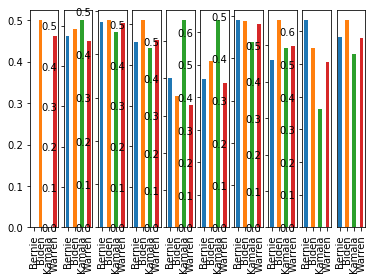

In [6]:
import matplotlib.pyplot as plt
data=[x for x in new_df["Percent_positive"]]
idx=["Bernie","Biden","Kamala","Warren"]*10
# how many bar charts we expect
ser= pd.Series(data,index=idx)
numofcharts = len(ser) / 4
print(len(ser))
print(type(numofcharts)) 
# prepare axes for subplots (1 row, numofcharts columns one per bar chart)
fig, axs = plt.subplots(1, int(numofcharts))
d=0
for graphi in range(int(numofcharts)):
    starti = 4*graphi
    d+=1
# create subseries one for each subchart
    subser = ser[starti:starti+4]
# print subseries, to see, what we are going to plot
#    print (subser)
# plot subseries as bar subchart
    subser.plot(ax=axs[graphi], kind="bar")

    
plt.yticks([])
plt.show()

In [7]:
newer_df=new_df.reset_index()
newer_df
#from ggplot import *

#ggplot(aes(x='Height', y='Weight', color='Gender'), data=df)  + geom_point()

,level_0,level_1,pos,neg,Percent_positive
0,Bloomberg,Bernie,NaN,5,NaN
1,Bloomberg,Biden,6.0,6,0.500000
2,Bloomberg,Kamala,NaN,2,NaN
3,Bloomberg,Warren,6.0,7,0.461538
4,Breitbart News,Bernie,484.0,538,0.473581
5,Breitbart News,Biden,1473.0,1525,0.491328
6,Breitbart News,Kamala,216.0,205,0.513064
7,Breitbart News,Warren,519.0,602,0.462979
8,CNN,Bernie,276.0,306,0.474227
9,CNN,Biden,883.0,962,0.478591


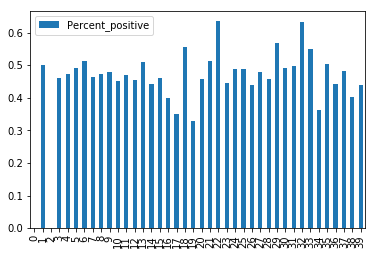

In [8]:
new_sources={}
for source, df_source in new_df.reset_index().groupby("level_0"):
    new_sources[source] = df_source   
new_sources

pd.DataFrame(newer_df["Percent_positive"]).plot(kind='bar')
plt.show()

In [9]:
## smae as above block but with no_duplicates=1
all_publishers2 = {}
pubnames = [x for x in sources.keys()]
for i, publisher in enumerate(pubnames):
   # pubs.append(get_sentiment_scores(names_list,publisher))
    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents', 1)
    print(scores)
    all_publishers2[publisher] = scores

{'Biden': Counter({'neg': 4, 'pos': 3}), 'Bernie': Counter({'neg': 2}), 'Warren': Counter({'neg': 4, 'pos': 4}), 'Kamala': Counter({'neg': 1})}
{'Biden': Counter({'neg': 1428, 'pos': 1359}), 'Bernie': Counter({'neg': 440, 'pos': 388}), 'Warren': Counter({'neg': 494, 'pos': 383}), 'Kamala': Counter({'pos': 179, 'neg': 170})}
{'Biden': Counter({'neg': 896, 'pos': 799}), 'Bernie': Counter({'neg': 243, 'pos': 207}), 'Warren': Counter({'neg': 344, 'pos': 284}), 'Kamala': Counter({'neg': 98, 'pos': 80})}
{'Biden': Counter({'neg': 1958, 'pos': 1943}), 'Bernie': Counter({'neg': 458, 'pos': 349}), 'Warren': Counter({'neg': 578, 'pos': 430}), 'Kamala': Counter({'neg': 219, 'pos': 159})}
{'Biden': Counter({'neg': 16, 'pos': 12}), 'Bernie': Counter({'neg': 20, 'pos': 15}), 'Warren': Counter({'neg': 27, 'pos': 15}), 'Kamala': Counter({'pos': 5, 'neg': 1})}
{'Biden': Counter({'pos': 106, 'neg': 101}), 'Bernie': Counter({'neg': 28, 'pos': 24}), 'Warren': Counter({'neg': 26, 'pos': 19}), 'Kamala': Cou

In [10]:
new_df2= pd.DataFrame.from_dict({(i,j): all_publishers2[i][j] 
                           for i in all_publishers2.keys() 
                           for j in all_publishers2[i].keys()},
                       orient='index')

new_df2['Percent_positive'] =   new_df2['pos']/(new_df2['pos']+new_df2['neg'])
new_df2

neg     pos  Percent_positive
Bloomberg               Bernie     2     NaN               NaN
                        Biden      4     3.0          0.428571
                        Kamala     1     NaN               NaN
                        Warren     4     4.0          0.500000
Breitbart News          Bernie   440   388.0          0.468599
                        Biden   1428  1359.0          0.487621
                        Kamala   170   179.0          0.512894
                        Warren   494   383.0          0.436716
CNN                     Bernie   243   207.0          0.460000
                        Biden    896   799.0          0.471386
                        Kamala    98    80.0          0.449438
                        Warren   344   284.0          0.452229
Fox News                Bernie   458   349.0          0.432466
                        Biden   1958  1943.0          0.498077
                        Kamala   219   159.0          0.420635
                        Warren   578   430.0          0.426587
Google News             Bernie    20    15.0          0.428571
                        Biden     16    12.0          0.428571
                        Kamala     1     5.0          0.833333
                        Warren    27    15.0          0.357143
MSNBC                   Bernie    28    24.0          0.461538
                        Biden    101   106.0          0.512077
                        Kamala     5    12.0          0.705882
                        Warren    26    19.0          0.422222
New York Magazine       Bernie   150   128.0          0.460432
                        Biden    386   345.0          0.471956
                        Kamala    56    36.0          0.391304
                        Warren   197   163.0          0.452778
The New York Times      Bernie   138   110.0          0.443548
                        Biden    236   298.0          0.558052
                        Kamala    29    24.0          0.452830
                        Warren   159   145.0          0.476974
The Wall Street Journal Bernie    13    14.0          0.518519
                        Biden     64    73.0          0.532847
                        Kamala     7     2.0          0.222222
                        Warren    36    39.0          0.520000
The Washington Post     Bernie  1048   784.0          0.427948
                        Biden   3062  2778.0          0.475685
                        Kamala   499   316.0          0.387730
                        Warren  1315   946.0          0.418399

## Need to look into this tokenizer, it should tokenize paragraphs but i couldn't install it

In [11]:
# from estnltk import Tokenizer
# tokenizer = Tokenizer()
# document = tokenizer.tokenize(text)

## Extra code from previous project

In [12]:
`
sns.set_style("darkgrid")


def name_entity_recognition(sentence):
    '''
    A function to retrieve name entities in a sentence.
    :param sentence: the sentence to retrieve names from.
    :return: a name entity list of the sentence.
    '''

    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON']]
    # convert all names to lowercase and remove 's and ’s in names
    name_entity = [str(x).lower().replace("'s", "") for x in name_entity]
    name_entity = [x.replace("’s", "") for x in name_entity]
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]

    return name_entity


def flatten(l):
    """A function that flattens a complex list"""
    flat_list = []
    for i in l:
        for j in i:
            flat_list.append(j)
    return flat_list


def nlist(book):
    """Returns a unique list of names from a sentence tokenized book"""
    names = []
    for i in book:
        if name_entity_recognition(i) != []:
            names.append(name_entity_recognition(i))
    names = list(set(flatten(names)))
    return names


def top_names(name_list, novel, top_num=25):
    '''
    Returns name freq of a book for each name
    '''

    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(
        name_frequency.toarray(), columns=vect.get_feature_names())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names


def name_freq_plot(df, title):
    """plot for name freq"""
    sns.barplot(data=df,
                y=df.names,
                x=df.freq,
                color='blue')
    plt.title(title)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-12-ed1e1bd63468>, line 1)

## Builds a dictionary which stores all the names used in all articles from CNN via Spacy-NER

In [ ]:
# this will build a dictionary which stores all the names used in all articles from CNN
sources["CNN"]['tokenized_sents'] = sources["CNN"].apply(
    lambda row: nltk.sent_tokenize(row['full_art']), axis=1)
article_dict = {}
for i, x in enumerate(sources["CNN"]['tokenized_sents']):
    article_dict[i] = nlist(x)
    print(i)

In [ ]:
features = []
        results = []
        features = [s1.find_features(x) for x in candidate]
        results = [s1.classifier.classify(x) for x in features]
        counter = collections.Counter(results)
all_publishers = {}
pubnames = [x for x in sources.keys()]
for i, publisher in enumerate(pubnames):
   # pubs.append(get_sentiment_scores(names_list,publisher))
    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents')
    print(scores)
    all_publishers[publisher] = scores

In [14]:
newer_df[newer_df['level_1']== "Bernie"]

,level_0,level_1,pos,neg,Percent_positive
0,Bloomberg,Bernie,NaN,5,NaN
4,Breitbart News,Bernie,484.0,538,0.473581
8,CNN,Bernie,276.0,306,0.474227
12,Fox News,Bernie,482.0,574,0.456439
16,Google News,Bernie,20.0,30,0.400000
20,MSNBC,Bernie,32.0,38,0.457143
24,New York Magazine,Bernie,190.0,198,0.489691
28,The New York Times,Bernie,145.0,171,0.458861
32,The Wall Street Journal,Bernie,26.0,15,0.634146
36,The Washington Post,Bernie,1059.0,1330,0.443282


In [51]:
candidate_names=newer_df['level_1'].unique()

    

E:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes usi

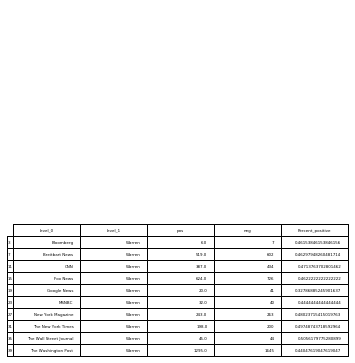

In [38]:
from tabulate import tabulate
import pandas as pd

for cand in candidate_names:
    ax = plt.subplot(111, frame_on=False) # no visible frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    table(ax, newer_df[newer_df['level_1']== cand])  # where df is your data frame
    plt.savefig('mytable{}.png'.format(cand))

In [62]:
for cand in candidate_names:
    cand_df=newer_df[newer_df['level_1']== cand] 
    cand_df=cand_df[cand_df['level_0']!= "Bloomberg"] 
    cand_df.loc['MEAN'] =  cand_df.mean()
    cand_df.loc['MEAN']=['NA','NA','NA','NA',cand_df.loc["MEAN"].pos/(cand_df.loc["MEAN"].pos+cand_df.loc["MEAN"].neg)]
    cand_df.style.applymap('font-weight: bold',
                  subset=pd.IndexSlice[cand_df.index[cand_df.index=='MEAN'], :])
    print(tabulate(cand_df, headers='keys', tablefmt='psql'))



+------+-------------------------+-----------+--------+--------+--------------------+
|      | level_0                 | level_1   | pos    | neg    |   Percent_positive |
|------+-------------------------+-----------+--------+--------+--------------------|
| 4    | Breitbart News          | Bernie    | 484.0  | 538.0  |           0.473581 |
| 8    | CNN                     | Bernie    | 276.0  | 306.0  |           0.474227 |
| 12   | Fox News                | Bernie    | 482.0  | 574.0  |           0.456439 |
| 16   | Google News             | Bernie    | 20.0   | 30.0   |           0.4      |
| 20   | MSNBC                   | Bernie    | 32.0   | 38.0   |           0.457143 |
| 24   | New York Magazine       | Bernie    | 190.0  | 198.0  |           0.489691 |
| 28   | The New York Times      | Bernie    | 145.0  | 171.0  |           0.458861 |
| 32   | The Wall Street Journal | Bernie    | 26.0   | 15.0   |           0.634146 |
| 36   | The Washington Post     | Bernie    | 1059.0 

In [76]:
?tabulate

In [77]:
candidate_names=newer_df['level_0'].unique()
def df_style(val):
    return 'font-weight: bold'
        
for cand in candidate_names:
    cand_df=newer_df[newer_df['level_0']== cand] 
    cand_df.loc['MEAN'] = cand_df.mean()
    cand_df.style.applymap('font-weight: bold',
                  subset=pd.IndexSlice[cand_df.index[cand_df.index=='MEAN'], :])
    print(tabulate(cand_df, headers='keys', tablefmt='psql'))
    
    

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


+------+-----------+-----------+-------+-------+--------------------+
|      | level_0   | level_1   |   pos |   neg |   Percent_positive |
|------+-----------+-----------+-------+-------+--------------------|
| 0    | Bloomberg | Bernie    |   nan |     5 |         nan        |
| 1    | Bloomberg | Biden     |     6 |     6 |           0.5      |
| 2    | Bloomberg | Kamala    |   nan |     2 |         nan        |
| 3    | Bloomberg | Warren    |     6 |     7 |           0.461538 |
| MEAN | nan       | nan       |     6 |     5 |           0.480769 |
+------+-----------+-----------+-------+-------+--------------------+
+------+----------------+-----------+-------+--------+--------------------+
|      | level_0        | level_1   |   pos |    neg |   Percent_positive |
|------+----------------+-----------+-------+--------+--------------------|
| 4    | Breitbart News | Bernie    |   484 |  538   |           0.473581 |
| 5    | Breitbart News | Biden     |  1473 | 1525   |           0

pos                 1457.500000
neg                 1716.000000
Percent_positive       0.442506
dtype: float64

level_0                  NaN
level_1                  NaN
pos                  373.667
neg                  443.889
Percent_positive    0.454746
Name: MEAN, dtype: object